## CBIR CON SIFT

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random

In [3]:
n_imgs = 100
carpetas = ["autobus-n04487081", "clavos-n03804744", "coche-n02814533", "collarin-n03814639", "desatascador-n03970156",
         "gatos-n02123394", "mono-n02480495", "puentes-n04532670", "silla-n04099969", "perro-n02099601", 
            "pato-n01855672", "pizza-n07873807", "mar-n09428293", "ipod-n03584254", "platano-n07753592", "mascara_gas-n03424325", 
            "pajarita-n02883205", "mosca-n02190166", "helado-n07615774", "canon-n02950826"]
len(carpetas)

20

In [4]:
def get_images_path(carpetas, n_imgs):
    images_path = {}
    for carpeta in carpetas:
        for i in range(n_imgs):
            images_path[(carpeta[-7:], str(i))] = f'./dataset/{carpeta}/{carpeta[-9:]}_{str(i)}.JPEG'
    return images_path #Devuelve un diccionario en el que la clave es (carpeta, id), y los valores los paths

In [5]:
images_path = get_images_path(carpetas, n_imgs)
len(images_path)

2000

Definimos funciones que nos seran utiles posteriormente

In [6]:
def get_n_similar(n, counts, reverse):
    sorted_counts = sorted(counts.items(), key=lambda x:x[1], reverse=reverse)[:n] #Ordeno y me quedo con los 5 más parecidos
    sorted_indexes = [idx[0] for idx in sorted_counts]
    return sorted_indexes

def display_n_similar(sorted_indexes, n):
    if n <= 0:
        print("El valor de n debe ser mayor que 0.")
        return

    if n > len(sorted_indexes):
        print(f"Solo hay {len(sorted_indexes)} imágenes en la lista. Mostrando todas.")
        n = len(sorted_indexes)
    fig, axs = plt.subplots(1, n, figsize=(15,15))
    for i in range(n):
        n_carpeta = (sorted_indexes[i][0])
        n_img = (sorted_indexes[i][1])
        path = images_path[(n_carpeta, n_img)]
        im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        axs[i].imshow(im)
        axs[i].axis('off')
        titulo = f'{n_carpeta}_{n_img}'
        axs[i].set_title(titulo)
        

    plt.show()

Para este proyecto vamos a usar un subconjunto de imagenes de imagenet

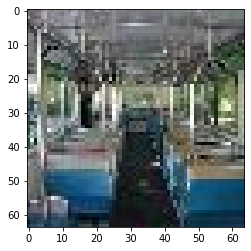

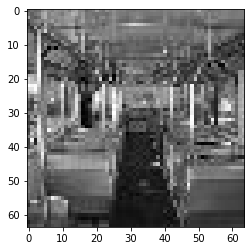

In [7]:
im1 = cv2.imread(list(images_path.values())[0])
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
plt.imshow(im1)
plt.show()
gray_im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_im1, cmap='gray')
plt.show()

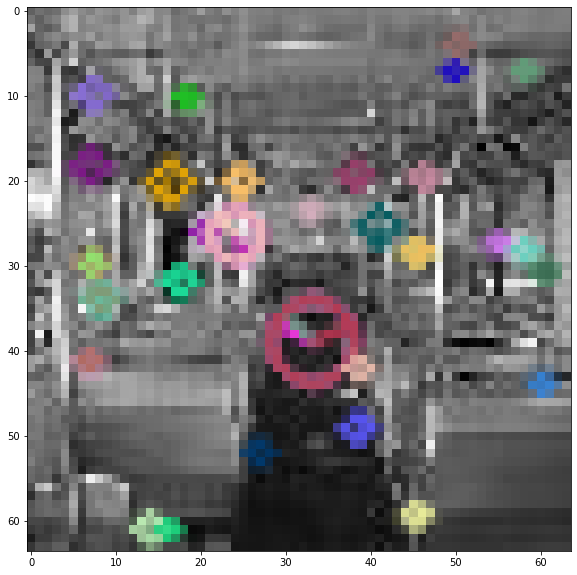

In [8]:
sift = cv2.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(gray_im1, mask=None)
im1_sift = cv2.drawKeypoints(gray_im1, keypoints_1, im1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(10,10))
plt.imshow(im1_sift)
plt.show()

Creamos una matriz numpy donde almacenaremos todos los descriptores con la etiqueta de la imagen a la q pertenecen

In [9]:
sift = cv2.SIFT_create()
descriptors = np.empty((0,130))

for idx in images_path:
    gray_im = cv2.cvtColor(cv2.imread(images_path[idx]), cv2.COLOR_BGR2GRAY)
    _, descriptor = sift.detectAndCompute(gray_im, mask=None)
    descriptors_arr = np.array(descriptor)
    if np.any(descriptors_arr):    
        descriptors_arr = np.insert(descriptors_arr, 0, idx[1], axis=1)
        descriptors_arr = np.insert(descriptors_arr, 0, idx[0], axis=1)
        descriptors =  np.vstack([descriptors, descriptors_arr]) #Pos 0 -> carpeta, Pos 1 -> numero de imagen


In [10]:
descriptors.shape

(72594, 130)

Entrenamos knn

In [11]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='euclidean')

descriptors_train = descriptors[:, 2:] #Quitamos los dos primeros pertenecientes a indices de la imagen
knn.fit(descriptors_train)

NearestNeighbors(metric='euclidean')

La estrategia para determinar las imagenes mas similares sera la siguiente:

1.- Obtenemos para cada descriptor de la imagen nueva sus 5 descriptores mas cercanos.

2.- Obtenemos los ID de las imagenes a las que pertenecen dichos descriptores.

3.- Almacenamos en un diccionario el numero de veces que aparece un descriptor de cada imagen.

4.- Recuperamos las n imagenes con mayor numero de descriptores coincidentes con los de la imagen nueva.

In [23]:
counts = {}
new_image_path = list(images_path.values())[random.randrange(0, len(carpetas)*n_imgs - 1)]
new_img = cv2.cvtColor(cv2.imread(new_image_path), cv2.COLOR_BGR2RGB)

_ , new_descriptors = sift.detectAndCompute(new_img, mask=None)
for descriptor in new_descriptors:
    descriptor = descriptor.reshape(1, -1)
    distance, indice = knn.kneighbors(descriptor, n_neighbors=5)
    for idx in indice[0]:
        carpeta = str(int(descriptors[idx,0]))
        num_img = str(int(descriptors[idx,1]))
        id = (carpeta, num_img)
        if id in counts:
            counts[id] += 1
        else:
            counts[id] = 1

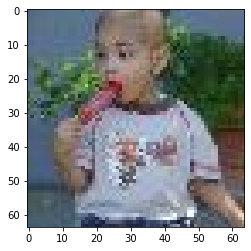

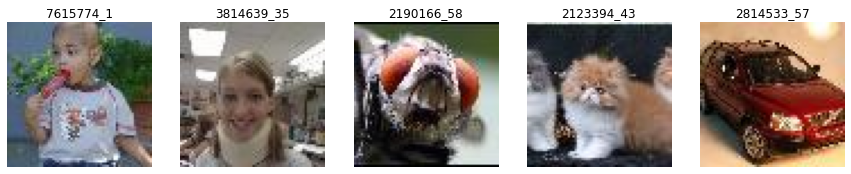

In [24]:
plt.imshow(new_img)
idx_similar = get_n_similar(5, counts, 1)
display_n_similar(idx_similar, 5)

## SIFT2

Ahora implementaremos otra forma de medir la similaridad entre 2 imagenes. Ahora, en vez de quedarnos con los n vecinos mas cercanos vamos a obtener todos, y de esta forma obtendremos todas las combinaciones posibles entre descriptores y obtendremos sus respectivas distancias.

Una vez tenemos las distancias de cada descriptor de cada imagen procedemos a calcular la media de las distancias, de forma que las imagenes se organizaran segun la media de distancias de sus descriptores.

In [15]:
from sklearn.neighbors import NearestNeighbors
n_descriptors = len(descriptors)
knn = NearestNeighbors(n_neighbors=n_imgs, algorithm='auto', metric='euclidean')

descriptors_train = descriptors[:, 2:]
knn.fit(descriptors_train)

counts = {}

new_image_path = list(images_path.values())[random.randrange(0, len(carpetas)*n_imgs - 1)]
new_img = cv2.cvtColor(cv2.imread(new_image_path), cv2.COLOR_BGR2RGB)
_ , descriptor = sift.detectAndCompute(new_img, mask=None)
descriptors_arr = np.array(descriptor)
for descriptor_i in descriptor:
    descriptor_i = descriptor_i.reshape(1, -1)
    distance, indice = knn.kneighbors(descriptor_i, n_neighbors=n_imgs)
    idx_dist = list(zip(indice[0], distance[0]))
    for tupl in idx_dist:
        carpeta = str(int(descriptors[tupl[0],0]))
        num_img = str(int(descriptors[tupl[0],1]))
        id = (carpeta, num_img)
        if id in counts:
            counts[id] += [tupl[1]]
        else:
            counts[id] = [tupl[1]]

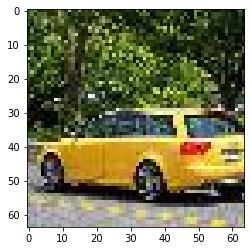

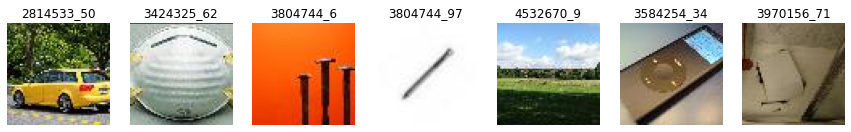

In [16]:
from statistics import mean
avg_distances = {clave: mean(valores) for clave, valores in counts.items()}
plt.imshow(new_img)
sorted_indexes = get_n_similar(10, avg_distances, 0)
display_n_similar(sorted_indexes, 7)